In [1]:
##########################################################################
# ADD SOME GENERAL INFO and LICENSE -> @ajay6763
##########################################################################
from __future__ import division
import sys,os,time
import obspy
from obspy.taup import TauPyModel
from obspy.geodetics import locations2degrees
from obspy.geodetics.base import gps2dist_azimuth
from obspy.geodetics.base import gps2dist_azimuth

from obspy.signal.trigger import recursive_sta_lta_py
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import matplotlib.transforms as mtransforms
import pygmt
import csv
import pandas as pd
import bp_lib
from joblib import Parallel, delayed
import obspy.geodetics

In [3]:
name = 'KYR_7.0_USA_13.0km_iasp91_0.8_corr_0.1_grid' #str(Event)+'_'+str(Exp_name)
outdir = name
path = os.getcwd()
scale=5
peak_scale=7
input = pd.read_csv('./'+name+'/input.csv',header=None)
a=input.to_dict('series')
keys = a[0][:]
values = a[1][:]
res = {}
for i in range(len(keys)):
        res[keys[i]] = values[i]
        #print(keys[i],values[i])
bp_l                = float(res['bp_l']) #Hz
bp_u                = float(res['bp_u'])   #Hz
smooth_time_window  = int(res['smooth_time_window'])   #seconds
smooth_space_window = int(res['smooth_space_window'])
stack_start         = int(res['stack_start'])   #in seconds
stack_end           = int(res['stack_end'])  #in seconds
STF_start           = int(res['STF_start'])
STF_end             = int(res['STF_end'])
sps                 = int(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
smooth_time_window=5
smooth_space_window=5
STF_start=0
STF_end=40
stack_start=30
stack_end=70
bp_l=0.8
bp_u=5.0
##########################################################################
# Event info
Event=res['Event']
event_lat=float(res['event_lat'])
event_long=float(res['event_long'])
event_depth=float(res['event_depth'])
Array_name=res['Array_name']
#Exp_name=res['Exp_name']
azimuth_min=float(res['azimuth_min'])
azimuth_max=float(res['azimuth_max'])
dist_min=float(res['dist_min'])
dist_max=float(res['dist_max'])
origin_time=obspy.UTCDateTime(int(res['origin_year']),int(res['origin_month']),
             int(res['origin_day']),int(res['origin_hour']),int(res['origin_minute']),float(res['origin_seconds']))
print(origin_time)
Focal_mech = dict(strike=float(res['event_strike']), dip=float(res['event_dip']), rake=float(res['event_rake'])
                 , magnitude=float(res['event_magnitude']))
model               = TauPyModel(model=str(res['model']))
sps                 = int(res['sps'])  #samples per seconds
threshold_correlation=float(res['threshold_correlation'])
SNR=float(res['SNR'])
#smooth_time_window  = int((stack_end-stack_start)/10) #int(res['smooth_time_window'])   #seconds
source_grid_size    = float(res['source_grid_size']) #degrees
source_grid_extend  = float(res['source_grid_extend'])   #degrees
source_depth_size   = float(res['source_depth_size']) #km
source_depth_extend = float(res['source_grid_extend']) #km
beam_file='beam_'+str(bp_l)+'_'+str(bp_u)+'_'+str(Array_name)+'.dat'
print('Beam file in :',beam_file)
stations_file = str(res['stations'])
stream_for_bp= obspy.read('./'+name+'/stream.mseed') 
beam = np.loadtxt('./'+name+'/'+beam_file)
beam_i = np.load('./'+name+'/beam_info.npy',allow_pickle=True)

stream_info = np.load('./'+name+'/array_bp_info.npy',allow_pickle=True)
print('#############################################################################\n')
print('Exp:',name)
print('Origin time:',origin_time)
print('Long= %f Lat= %f Depth= %f' % (event_long,event_lat,event_depth))
#print('bp_low= %f bp_high= %f Correlation threshold= %f SNR= %f'% (bp_l,bp_u,threshold_correlation,SNR))
print('#############################################################################\n')


sta_name=list(stream_info[:,1])
for t in stream_for_bp:
        if len(t.stats['station'].split('.')) > 1:
            sta          = t.stats.station+str('H')
        else:
            sta          = t.stats.station
        #net 
        if sta in sta_name:
            ind                          = sta_name.index(sta)
            t.stats['origin_time']       = origin_time
            t.stats['station_longitude'] = float(stream_info[ind,2])
            t.stats['station_latitude']  = float(stream_info[ind,3])
            t.stats['Dist']              = float(stream_info[ind,4])
            t.stats['Azimuth']           = float(stream_info[ind,5])
            arrivals                     = model.get_travel_times(source_depth_in_km=event_depth,distance_in_degree=t.stats.Dist,phase_list=["P"])
            arr                          = arrivals[0]
            t_travel                     = arr.time
            t.stats['P_arrival']         = origin_time + t_travel 
        
            #t.stats['P_arrival']         = float(stream_info[ind,6]) 
            t.stats['Corr_coeff']        = float(stream_info[ind,7])
            t.stats['Corr_shift']        = float(stream_info[ind,8])
            t.stats['Corr_sign']         = float(stream_info[ind,9])
        else:
            pass
            #print('Something is not right.')


Ref_station_index=bp_lib.get_ref_station(stream_for_bp)
ref_trace = stream_for_bp[Ref_station_index]


2024-01-22T18:09:04.000000Z
Beam file in : beam_0.8_5.0_USA.dat
#############################################################################

Exp: KYR_7.0_USA_13.0km_iasp91_0.8_corr_0.1_grid
Origin time: 2024-01-22T18:09:04.000000Z
Long= 78.649000 Lat= 41.269000 Depth= 13.000000
#############################################################################



In [4]:
import math
tr=stream_for_bp[0]
amp=tr.data
time = np.arange(0, len(amp)/ tr.stats.sampling_rate, tr.stats.delta)
baz = gps2dist_azimuth(event_lat, event_long,
                       tr.stats.station_latitude, tr.stats.station_longitude)
BAZ=np.zeros_like(amp)+baz[2]
dev=np.zeros_like(BAZ)
for i in range(len(BAZ)):
    dev[i]=math.atan(amp[i]/(1/tr.stats.sampling_rate))
#plt.plot(time,dev+BAZ)
r_plot=BAZ+dev



C:\Users\ajay6\AppData\Local\Temp\ipykernel_10608\1409325855.py:5: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  baz = gps2dist_azimuth(event_lat, event_long,


In [5]:
fig = pygmt.Figure()
pygmt.config(FONT_TITLE="12p,Helvetica,black", FORMAT_GEO_MAP="+D")
# ============
# top left
STF_end=30
scale=10
stack_start=0
fig.basemap(region=[-180, 180, stack_start, STF_end],
    # set map width to 5 cm
    projection="P5c+a",
    # set the frame, color, and title
    # @^ allows for a line break within the title
    frame=["xa45f10"],
    #frame=["xa45f", "+gbisque+tprojection='P5c' @^ region=[0, 360, 0, 1]"],
)
stream_out=stream_for_bp.copy()
for tr in stream_out:
    st_time=tr.stats['P_arrival']+tr.stats['Corr_shift']-5
    end_time=st_time+length
    #tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
    tr.trim(st_time,end_time)
    tr.normalize()
    amp = tr.data*tr.stats['Corr_sign']  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
    amp=amp/np.max(amp) #+ count
    time = np.arange(0, len(amp)/ tr.stats.sampling_rate, tr.stats.delta)
    #baz = gps2dist_azimuth(event_lat, event_long, 
    #                       tr.stats.station_latitude, tr.stats.station_longitude)
    BAZ=np.zeros_like(amp)+tr.stats.Azimuth #baz[2]
    #dev=np.zeros_like(BAZ)
    #for i in range(len(BAZ)):
    #    dev[i]=math.atan(amp[i]/(1/tr.stats.sampling_rate))*5
    #peak_cmap=pygmt.makecpt(cmap="seis", series=[-1, 1,  1/10])
    r_plot=BAZ+amp*scale
    fig.plot(x=r_plot,y=time,pen="0.1p,grey",
    
)
fig.show()

NameError: name 'length' is not defined

In [107]:
fig = pygmt.Figure()

fig.plot(x=time,y=amp, region=[0, 360, 0, 100],projection="P10c/10c",
    pen="0.5p,black",
)
fig.show()

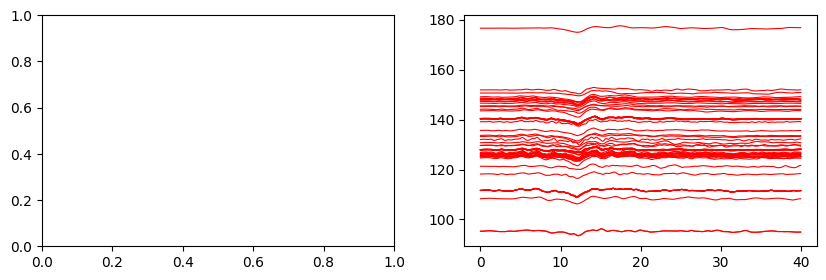

In [67]:
fig, ax = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(10,3))
width = 28e6
stream_out=stream_for_bp.copy()
for tr in stream_out:
    st_time=tr.stats['P_arrival']+tr.stats['Corr_shift']
    end_time=st_time+40
    tr.trim(st_time,end_time)
    tr.normalize()
    cut = tr.data*tr.stats['Corr_sign']  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
    cut=cut/np.max(cut) #+ count
    cut=cut+tr.stats['Azimuth']
    time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
    ax[1].plot(time,cut,color='red',linewidth=0.8)


In [8]:
from mpl_toolkits.basemap import Basemap
def array_plot(stream,event_lat,event_long):
    fig, ax = plt.subplots(1, 2, sharex=False, sharey=False,figsize=(10,3))
    #map =  Basemap(projection='cyl', lon_0=event_long,lat_0=event_lat,
    #        resolution='c',ax=ax[0])
    width = 28e6
    #map = Basemap(width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c',ax=ax[1])
    map = Basemap(ax=ax[0],width=width,height=width,projection='aeqd',lon_0=event_long,lat_0=event_lat,resolution='c')
    strea_out=stream.copy()
    Ref_trace_ind =bp_lib.get_ref_station(stream)
    ref_trace=stream[Ref_trace_ind]
    count=0
    for tr in stream:
        count=count+1
        if tr.stats.station == ref_trace.stats.station:
            tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
            
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            #tr.plot(starttime=t.stats.P_arrival-30,endtime=t.stats.P_arrival+60,type='relative')
            #tr.plot(type='relative')
            st_time=tr.stats['P_arrival']+tr.stats['Corr_shift']
            end_time=st_time+40
            #print('P_arrive , St_time , end_time: ',(tr.stats['P_arrival'],st_time,end_time))
            tr.trim(st_time,end_time)
            tr.normalize()
            cut = tr.data*tr.stats['Corr_sign']  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            #cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) #+ count
            cut=cut+count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut,color='red',linewidth=0.8)
            #ax[1].plot(time,tr.data,color='gray')
        else:
            map.scatter(tr.stats.station_longitude,tr.stats.station_latitude,latlon=True,facecolor='blue',marker='^')
            tr.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
            
            st_time=tr.stats['P_arrival']+tr.stats['Corr_shift']
            end_time=st_time+40
            #print('P_arrive , St_time , end_time: ',(tr.stats['P_arrival'],st_time,end_time))
            tr.trim(st_time,end_time)
            tr.normalize()
            cut = tr.data*tr.stats['Corr_sign']  #bp_lib.cut_window(tr, t_corr, -5, STF_end)[0]
            #cut=cut*tr.stats['Corr_sign']*tr.stats['Corr_coeff']
            cut=cut/np.max(cut) #+ count
            cut=cut+count
            time = np.arange(0, len(cut)/ tr.stats.sampling_rate, tr.stats.delta)
            ax[1].plot(time,cut,color='grey',linewidth=0.5)
            #ax[1].plot(time,tr.data,color='gray')
    map.scatter(event_long,event_lat,latlon=True,facecolor='red',marker='*')
    map.drawcoastlines(linewidth=0.1)
    x, y = map(event_long, event_lat)
    #focmecs = Focal_mech
    #ax = plt.gca()
    #b = beach(focmecs, xy=(x, y), width=10, linewidth=1, alpha=0.85)
    #b.set_zorder(10000000)
    #ax.add_collection(b)
    ## plot traces
    plt.show()
    #return stream_sorted
    #fig.savefig(outdir'/'+outname)

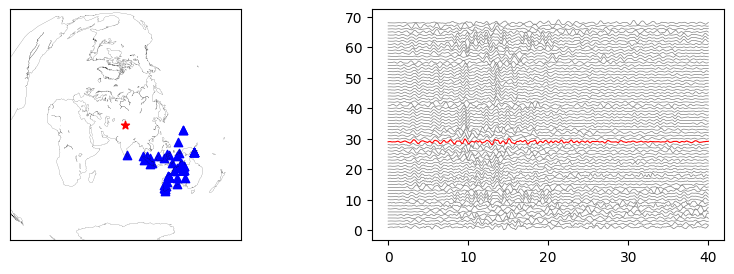

In [9]:
array_plot(stream_for_bp,event_lat,event_long)

In [53]:
stream=stream_for_bp.copy()
#stream.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
t1=stream[3]
t2=stream[9]
obspy.signal.cross_correlation.xcorr_pick_correction(t1.stats.P_arrival,t1,
                                                     t2.stats.P_arrival,t2,
                                                    20,20,20,filter=None)


C:\Users\ajay6\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\cross_correlation.py:524: UserWarning: Absolute maximum is negative: -0.420. Using positive maximum: 0.418
  warnings.warn(msg)
C:\Users\ajay6\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\cross_correlation.py:528: UserWarning: Maximum of cross correlation lower than 0.8: 0.41811833677452587
  warnings.warn(msg)


(-3.2764502192458056, 0.4129305893225431)

-1.545 0.544
-1.605 0.734


C:\Users\ajay6\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\cross_correlation.py:479: UserWarning: Trace ids do not match: G.ATD.00.BHZ != IV.SOLUN..BHZ
  warnings.warn(msg)
C:\Users\ajay6\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\cross_correlation.py:528: UserWarning: Maximum of cross correlation lower than 0.8: 0.5536829203822183
  warnings.warn(msg)
C:\Users\ajay6\AppData\Local\Programs\Python\Python312\Lib\site-packages\obspy\signal\cross_correlation.py:528: UserWarning: Maximum of cross correlation lower than 0.8: 0.7405300343480549
  warnings.warn(msg)


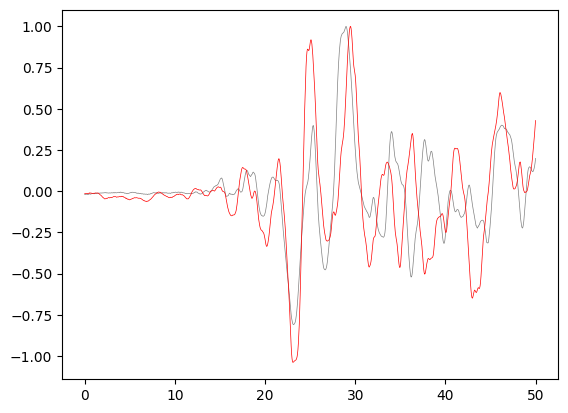

In [94]:
bp_l=0.5
bp_u=5.0
snr_window=20
stream=stream_for_bp.copy()
#stream.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
#t1=stream[3]
Ref_station_index=bp_lib.get_ref_station(stream)
t1 = stream[Ref_station_index]
t2=stream[7]
#t1.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
#t2.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
#cc=obspy.signal.cross_correlation.correlate(t1,t2,30)
#shift,corr=obspy.signal.cross_correlation.xcorr_max(cc)
#print(obspy.signal.cross_correlation.xcorr_max(cc))
shift,corr=obspy.signal.cross_correlation.xcorr_pick_correction(t1.stats.P_arrival,t1,
                                                     t2.stats.P_arrival,t2,
                                                    snr_window,STF_end,STF_end,
                                                                filter=None,
                                                                filter_options=
                                                                {'freqmin': bp_l, 'freqmax': bp_u})

print(round(shift,3),round(corr,3))
shift,corr=obspy.signal.cross_correlation.xcorr_pick_correction(t1.stats.P_arrival,t1,
                                                     t2.stats.P_arrival,t2,
                                                    20,10,10,filter=None,
                                                                filter_options={'freqmin': bp_l, 'freqmax': bp_u})

print(round(shift,3),round(corr,3))

t1.stats['Corr_shift']=0
#t1.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
st_time=t1.stats['P_arrival']+t1.stats['Corr_shift']-10
end_time=st_time+50
t1.trim(st_time,end_time)
t1.normalize()
cut=t1.data
cut=cut/np.max(cut) #+ count
time = np.arange(0, len(cut)/ t1.stats.sampling_rate, t1.stats.delta)
plt.plot(time,cut,color='grey',linewidth=0.5)

#t2.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
t2.stats['Corr_shift']=round(shift, 3)
st_time=t2.stats['P_arrival']+t2.stats['Corr_shift']-10
end_time=st_time+50
t2.trim(st_time,end_time)
t2.normalize()
cut=t2.data
cut=cut/np.max(cut) #+ count
time = np.arange(0, len(cut)/ t2.stats.sampling_rate, t2.stats.delta)
plt.plot(time,cut,color='red',linewidth=0.5)

-3.2398507189930394 0.39231262527497507


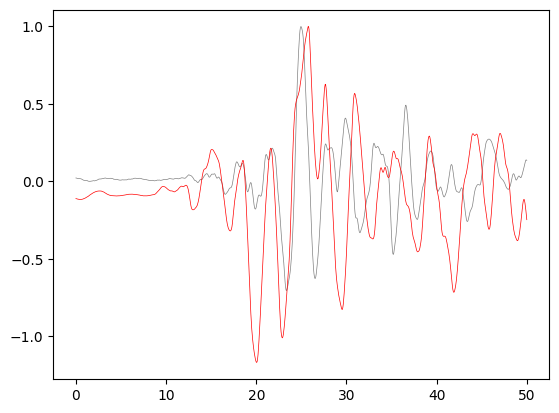

In [68]:
bp_l=0.5
bp_u=5.0
stream=stream_for_bp.copy()
#stream.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
t1=stream[3]
t2=stream[9]
#t1.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
#t2.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
#cc=obspy.signal.cross_correlation.correlate(t1,t2,30)
#shift,corr=obspy.signal.cross_correlation.xcorr_max(cc)
#print(obspy.signal.cross_correlation.xcorr_max(cc))
shift,corr=obspy.signal.cross_correlation.xcorr_pick_correction(t1.stats.P_arrival,t1,
                                                     t2.stats.P_arrival,t2,
                                                    10,30,10,filter=None)
print(shift,corr)
t1.stats['Corr_shift']=0
#t1.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
st_time=t1.stats['P_arrival']-10
end_time=st_time+50
t1.trim(st_time,end_time)
t1.normalize()
cut=t1.data
cut=cut/np.max(cut) #+ count
time = np.arange(0, len(cut)/ t1.stats.sampling_rate, t1.stats.delta)
plt.plot(time,cut,color='grey',linewidth=0.5)

#t2.filter('bandpass',freqmin=bp_l,freqmax=bp_u)
t2.stats['Corr_shift']=shift
st_time=t2.stats['P_arrival']-10
end_time=st_time+50
t2.trim(st_time,end_time)
t2.normalize()
cut=t2.data
cut=cut/np.max(cut) #+ count
time = np.arange(0, len(cut)/ t2.stats.sampling_rate, t2.stats.delta)
plt.plot(time,cut,color='red',linewidth=0.5)

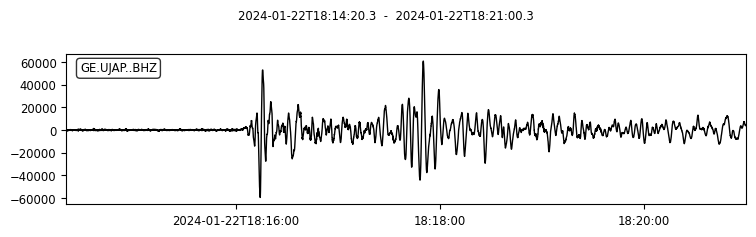

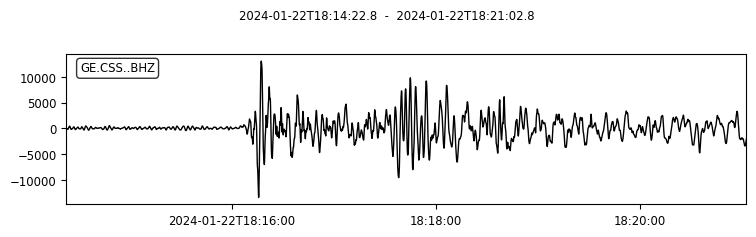

(19, 0.22217493964902307)

In [16]:
t1.plot();
t2.plot();
cc=obspy.signal.cross_correlation.correlate(t1,t2,20)
obspy.signal.cross_correlation.xcorr_max(cc)


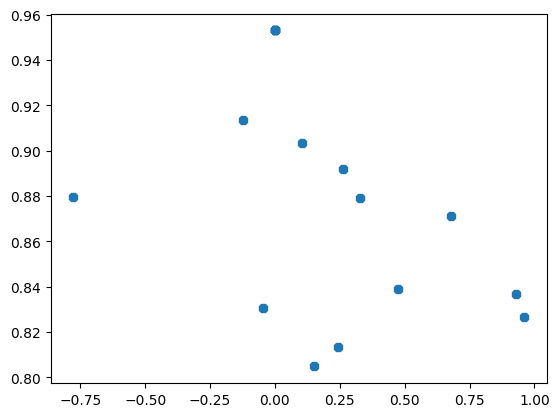

In [9]:
shift=[]
corr=[]
for t in stream_for_bp:
    shift.append(t.stats.Corr_shift)
    corr.append(t.stats.Corr_coeff)
#stream_selected.filter('bandpass',freqmin=0.5,freqmax=5.0)
plt.plot(shift,corr,'8')